## Problem Definition

In [349]:
import random
import numpy as np
import gym
from gym import spaces
import torch

from typing import List, Callable, Optional, Union

RANDOM_SEED = 42
SIGMA_NOISE = 0.05
torch.manual_seed(RANDOM_SEED)

from constants import DTYPE, FIG_HEIGHT, DPI, LABEL_FONT_SIZE

class CircleRotation(gym.Env):

    def __init__(self,
                 s_goals: List[np.array],
                 seed: int,
                 encoder: Optional[Callable[[np.array], np.array]] = None,
                 decoder: Optional[Callable[[np.array], np.array]] = None,
                 sigma_noise: float=SIGMA_NOISE):
        
        """Circle navigation environment.
        Encodes the state space via an encoder and updates reward and transition function with the decoder.
        Args:
        - s_goals, list of goal states
        - seed, int
        - encoder: Callable or None, encodes the state space.
        - decoder: Callable or None, decodes the state space again.
        - sigma_noise, float: Sigma of the normal noise in the transition function.
        """


        self.seed(seed)

        if encoder is not None:
            assert decoder is not None, "Provide a decoder if you provide an encoder."
        if decoder is not None:
            assert encoder is not None, "Provide an encoder if you provide a decoder."

        # State and action spaces
        self.sigma_noise = sigma_noise
        self.observation_space = spaces.Box(low=-2.0, high=2.0, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Box(low=-0.2, high=0.2, shape=(2,), dtype=np.float32)

        # Set encoder and decoder. Set to identity map if none are provided to shorten code.
        self.encoder = encoder if encoder is not None else lambda p: p
        self.decoder = decoder if decoder is not None else lambda p: p

        # Define goal state
        self.goal_states = s_goals
        self.goal_state = random.choice(self.goal_states).copy()

        # Define initial state
        self._point = np.array([0.0, 0.0], dtype=np.float32)
        self._point = self.encoder(self._point)
        dist = np.linalg.norm(self.decoder(self._point) - self.goal_state)
        self.s = self._point
        # self.s = np.concatenate([self._point, (dist,)])

        self.episode_length = 100
        self.step_count = 0


    def reset(self):

        '''
        Reset the system to its initial state. Samples a new task.
        '''
        self.step_count = 0

        #Reset state
        self._point = np.zeros_like(self.goal_state)
        self._point = self.encoder(self._point)
        self.goal_state = random.choice(self.goal_states).copy()
        dist = np.linalg.norm(self.decoder(self._point) - self.goal_state)
        self.s = self._point
        # self.s = np.concatenate([self._point, (dist,)])
        
        return self.s
    

    def step(self, u: np.array) -> Union[np.array, np.float32, bool, dict]:

        '''
        Step the system forward by one time step from state s with control input u. 
        Returns the next state, the cost and whether the episode is done.
        '''

        # Compute reward.
        dist = np.linalg.norm(self.decoder(self._point) - self.goal_state)
        reward = -dist
        self.step_count += 1

        # Check if episode is done.
        if self.step_count == self.episode_length-1 or np.allclose(self.decoder(self._point), self.goal_state, atol=0.2):
            done = True
            self.step_count = 0
            reward += 5
        else:
            done = False

        # Compute next state.
        self._point = self.decoder(self._point) + u
        self._point += np.random.normal(loc=0, scale=self.sigma_noise, size=2) if self.sigma_noise > 0 else 0
        
        ## Push-forward
        self._point = self.encoder(self._point)

        # self.s = np.concatenate([self._point, (dist,)])
        self.s = self._point

        return self.s, reward, done, {}
    

    def seed(self, seed=None):
        np.random.seed(seed)
        return [seed]

## Meta Setup

In [221]:
def generate_circle_points(angles):
    """Generates 2-D coordinates on a circle, given by an array of angles in radians."""
    x = RADIUS*np.cos(angles)
    y = RADIUS*np.sin(angles)
    points = np.stack((x, y), axis=1)
    return points

# Example
N_TOTAL_TASKS = 50
RADIUS=2
IDXS_TRAIN_TASKS = [0] #only use one task as geometry is global
CIRCLE_ANGLES = np.linspace(0, 2 * np.pi, N_TOTAL_TASKS, endpoint=False)
IDX_TEST_TASKS = set(range(N_TOTAL_TASKS)) - set(IDXS_TRAIN_TASKS)

goal_positions_all = generate_circle_points(CIRCLE_ANGLES)
goal_positions_train = [goal_positions_all[idx] for idx in IDXS_TRAIN_TASKS]
goal_positions_test = [goal_positions_all[idx] for idx in IDX_TEST_TASKS]

print("Goal Positions Train:")
for pos in goal_positions_train:
    print(pos.round(2))

print("\nGoal Positions Test:")
for pos in goal_positions_test:
    print(pos.round(2))

Goal Positions Train:
[2. 0.]

Goal Positions Test:
[1.98 0.25]
[1.94 0.5 ]
[1.86 0.74]
[1.75 0.96]
[1.62 1.18]
[1.46 1.37]
[1.27 1.54]
[1.07 1.69]
[0.85 1.81]
[0.62 1.9 ]
[0.37 1.96]
[0.13 2.  ]
[-0.13  2.  ]
[-0.37  1.96]
[-0.62  1.9 ]
[-0.85  1.81]
[-1.07  1.69]
[-1.27  1.54]
[-1.46  1.37]
[-1.62  1.18]
[-1.75  0.96]
[-1.86  0.74]
[-1.94  0.5 ]
[-1.98  0.25]
[-2. -0.]
[-1.98 -0.25]
[-1.94 -0.5 ]
[-1.86 -0.74]
[-1.75 -0.96]
[-1.62 -1.18]
[-1.46 -1.37]
[-1.27 -1.54]
[-1.07 -1.69]
[-0.85 -1.81]
[-0.62 -1.9 ]
[-0.37 -1.96]
[-0.13 -2.  ]
[ 0.13 -2.  ]
[ 0.37 -1.96]
[ 0.62 -1.9 ]
[ 0.85 -1.81]
[ 1.07 -1.69]
[ 1.27 -1.54]
[ 1.46 -1.37]
[ 1.62 -1.18]
[ 1.75 -0.96]
[ 1.86 -0.74]
[ 1.94 -0.5 ]
[ 1.98 -0.25]


## Plotting

In [ ]:
import matplotlib.pyplot as plt

def plot_rollouts_on_circle(train_trajectories,
                             test_trajectories,
                             train_goal_locations,
                             test_goal_locations,
                             idx_label_test=3,
                             legend: bool=False,
                             savepath: str=None):
    """Plots trajectories from the different tasks on the circle."""

    # 1. Set fixed figure size (square)
    fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

    use_label_train: bool = True
    label=None
    cmap = plt.get_cmap('hsv')

    num_trajs = len(test_trajectories)
    
    # Train distribution
    circle = plt.Circle((0, 0), RADIUS, color='black', fill=False, linestyle='--', linewidth=2, label=r'$p(\mathcal{T})$', zorder=3, alpha=0.3)
    ax.add_artist(circle)

    for idx_traj, test_traj in enumerate(test_trajectories):
        color = cmap(0.5 + 0.5 * idx_traj / max(1, num_trajs - 1))
        if idx_traj == idx_label_test:
            label = "Test"
            ax.plot(test_traj[:-1,0], test_traj[:-1,1], marker="x", color=color, alpha=1, label=label)
        else:
            ax.plot(test_traj[:-1,0], test_traj[:-1,1], marker="x", color=color, alpha=1, label=None)
        ax.scatter(test_goal_locations[idx_traj][0], test_goal_locations[idx_traj][1], color=color, marker="X", s=500)

    for idx_traj, train_traj in enumerate(train_trajectories):
        if use_label_train:
            label="Train"
            use_label_train=False
            ax.plot(train_traj[:-1,0], train_traj[:-1,1], marker="x", color="black", alpha=1, label=label)
        else:
            ax.plot(train_traj[:-1,0], train_traj[:-1,1], marker="x", color="black", alpha=1, label=None)
        ax.scatter(train_goal_locations[idx_traj][0], train_goal_locations[idx_traj][1], color="black", marker="X", s=500)


    ax.set_xlim(-RADIUS-0.5, RADIUS+0.5)
    ax.set_ylim(-RADIUS-0.5, RADIUS+0.5)
    ax.set_aspect('equal')
    ax.axis('off')

    if legend:
        ax.legend(ncols=4, loc='upper center', bbox_to_anchor=(0.5, 0.05), fontsize=LABEL_FONT_SIZE)

    # 2. Save figure
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', pad_inches=0.05, dpi=DPI)

    plt.show()

    plt.close(fig)

In [6]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
import os

# Training setup
N_ENVS=1 #does not learn for more envs as environment too simple!
N_STEPS=30_000

# Make the environment
env = CircleRotation(s_goals=goal_positions_train, seed=RANDOM_SEED)

# Optionally wrap in a vectorized env (recommended for SB3)
vec_env = make_vec_env(lambda: env, n_envs=N_ENVS, seed=RANDOM_SEED)

# Create the model
model = SAC("MlpPolicy", vec_env, verbose=1, seed=RANDOM_SEED)

# Train the model
model.learn(total_timesteps=N_STEPS)

/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -216     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 65       |
|    time_elapsed    | 6        |
|    total_timesteps | 396      |
| train/             |          |
|    actor_loss      | 0.985    |
|    critic_loss     | 0.26     |
|    ent_coef        | 0.916    |
|    ent_coef_loss   | -0.295   |
|    learning_rate   | 0.0003   |
|    n_updates       | 295      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.8     |
|    ep_rew_mean     | -187     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 58       |
|    time_elapsed    | 12       |
|    total_timesteps | 758      |
| train/             |          |
|    actor_loss      | 2.35     |
|    critic_loss     | 0.453   

## Roll-Out Policy on New Tasks

In [222]:
import matplotlib.pyplot as plt

def sample_traj_of_env(environment, trained_model):
    n_steps = 100
    obs = environment.reset()
    trajectory = []
    rewards = []
    actions = []
    trajectory.append(obs.copy())

    for _ in range(n_steps):
        action, _ = trained_model.predict(obs, deterministic=True)
        obs, reward, done, _ = environment.step(action)

        actions.append(action)
        trajectory.append(obs.copy())
        rewards.append(reward)

        if done:
            break

    trajectory = np.array(trajectory)
    rewards = np.array(rewards)
    actions = np.array(actions)

    return trajectory, actions, rewards

trajs_all_tasks_train = []
trajs_all_tasks_test = []
actions_all_tasks_train = []
actions_all_tasks_test = []
RANDOM_SEEDS_EVALUATION = np.random.choice(np.arange(10_000), size=N_TOTAL_TASKS, replace=False)

for idx_goal_position, goal_position in enumerate(goal_positions_all):
    test_env = CircleRotation(s_goals=[goal_position], seed=RANDOM_SEEDS_EVALUATION[idx_goal_position])
    traj, actions, rewards = sample_traj_of_env(test_env, model)
    if any(np.array_equal(goal_position, s_inits) for s_inits in goal_positions_train):
        trajs_all_tasks_train.append(traj)
        actions_all_tasks_train.append(actions)
        rewards_train=rewards
    else:
        trajs_all_tasks_test.append(traj)
        actions_all_tasks_test.append(actions)        
    del test_env

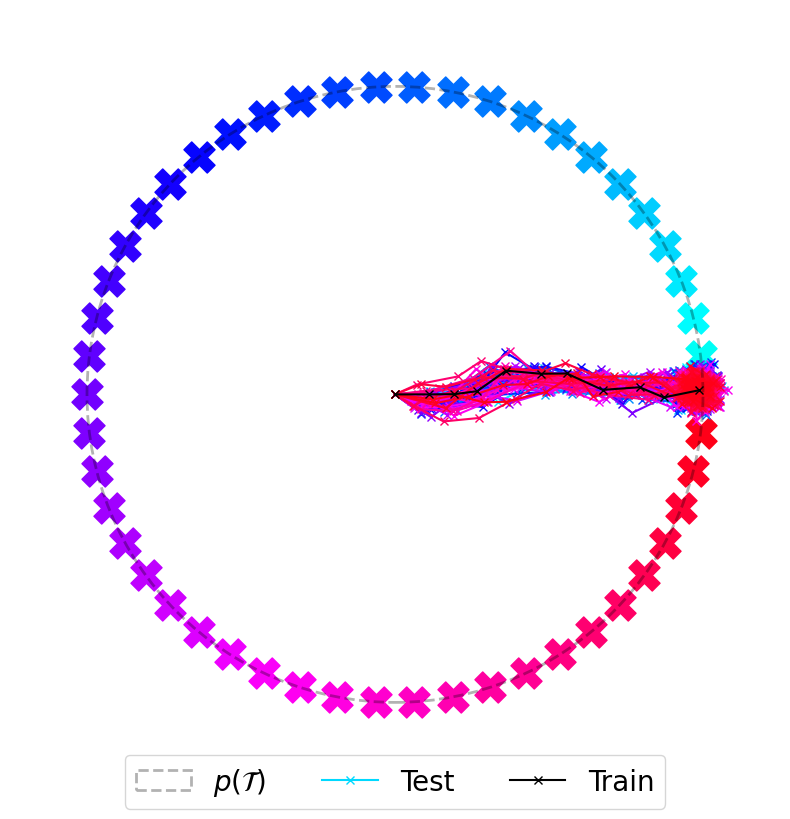

In [223]:
plot_rollouts_on_circle(train_trajectories=trajs_all_tasks_train,
                        test_trajectories=trajs_all_tasks_test,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_positions_test,
                        legend=True,
                        # savepath=None
                        savepath="circle_nav_vanilla_meta_rl"
                        )

## Hereditary Geometry (with ground-truth task encodings)

- No Encoder for symmetry yet

In [463]:
# LG = lambda theta : np.array([[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0], [0, 0, 1]]) #Runs counter-clockwise! Is inverse as shown in master thesis
LG = lambda theta : np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) #Runs counter-clockwise! Is inverse as shown in master thesis

def sample_traj_of_hereditary_env(base_task, base_policy, Lg, n_steps=100):
    """Rolls out a base policy in a new task by transforming the state and action spaces, not the reward and transition function."""

    # Trajectory of states, in the original state space representation
    traj_base = []

    # Get the state in the base task
    s_base = base_task.reset()
    # We record states in the base state representation to compare the different tasks. TODO, understand better why exactly we do this.
    traj_base.append(s_base.copy())

    # Push-forward the base state via l_g to the new task
    s_test = Lg @ s_base

    for _ in range(n_steps):
        # Sample the policy in state of the test task
        a_test, _ = base_policy.predict(s_test, deterministic=True)
        s_base, _, done, _ = base_task.step(a_test)

        # Push-forward the base state via l_g to the new task
        s_test = Lg @ s_base

        # We record states in the base state representation to compare the different tasks. TODO, understand better why exactly we do this.
        traj_base.append(s_base.copy())

        if done:
            break

    return np.array(traj_base)


trajs_her_env_train = []
trajs_her_env_test = []

# Create environment. Now, all tasks are in same environment.
hereditary_env = CircleRotation(s_goals=goal_positions_train, seed=RANDOM_SEED, encoder=None, decoder=None)
hereditary_env.reset()

for task_idx, goal_position in enumerate(goal_positions_all):
    g_action = CIRCLE_ANGLES[task_idx]
    Lg_test_task = LG(g_action)

    traj_equ = sample_traj_of_hereditary_env(base_task=hereditary_env, base_policy=model, Lg=Lg_test_task)

    if any(np.array_equal(goal_position, s_goal) for s_goal in goal_positions_train):
        trajs_her_env_train.append(traj_equ)
    else:
        trajs_her_env_test.append(traj_equ)


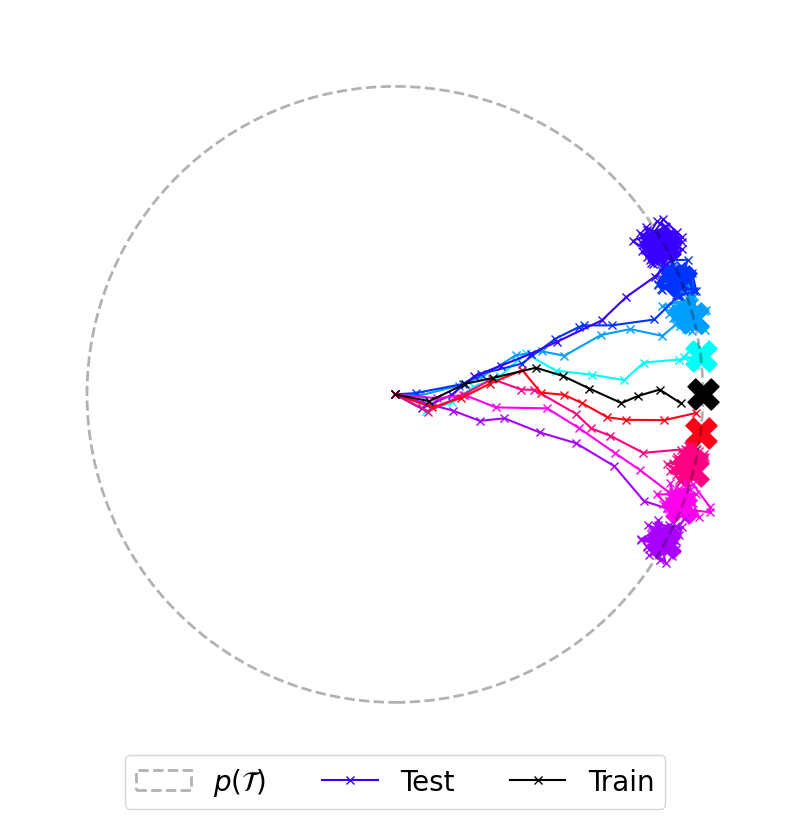

In [464]:
N_TRAJS_TO_PLOT=4
trajs_her_env_test_plot = trajs_her_env_test[:N_TRAJS_TO_PLOT] + trajs_her_env_test[-N_TRAJS_TO_PLOT:]
goal_pos_test_plot = goal_positions_test[:N_TRAJS_TO_PLOT] + goal_positions_test[-N_TRAJS_TO_PLOT:]

plot_rollouts_on_circle(train_trajectories=trajs_her_env_train,
                        test_trajectories=trajs_her_env_test_plot,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_pos_test_plot,
                        legend=True,
                        # savepath=None
                        savepath="circle_nav_hereditary_meta_rl"
                        )

## Train Symmetric Policy

In [30]:
ENCODER = lambda p : p - np.array([RADIUS,0], dtype=np.float32)
DECODER = lambda p : p + np.array([RADIUS,0], dtype=np.float32)


# Make the environment
encoded_env = CircleRotation(s_goals=goal_positions_train, 
                     encoder=ENCODER,
                     decoder=DECODER,
                     seed=RANDOM_SEED)

vec_encoded_env = make_vec_env(lambda: encoded_env, n_envs=N_ENVS, seed=RANDOM_SEED)

encoded_model = SAC("MlpPolicy", vec_encoded_env, verbose=1, seed=RANDOM_SEED)
del vec_encoded_env

encoded_model.learn(total_timesteps=N_STEPS)

/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -216     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 79       |
|    time_elapsed    | 4        |
|    total_timesteps | 396      |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 0.269    |
|    ent_coef        | 0.916    |
|    ent_coef_loss   | -0.295   |
|    learning_rate   | 0.0003   |
|    n_updates       | 295      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -186     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 70       |
|    time_elapsed    | 11       |
|    total_timesteps | 792      |
| train/             |          |
|    actor_loss      | 2.14     |
|    critic_loss     | 0.528   

In [226]:
encoded_trajs_all_tasks_train = []
encoded_trajs_all_tasks_test = []

for idx_goal_position, goal_position in enumerate(goal_positions_all):

    # Create environments, should be no change to vanilla Meta-RL.
    test_env = CircleRotation(s_goals=[goal_position], encoder=ENCODER, decoder=DECODER, seed=RANDOM_SEEDS_EVALUATION[idx_goal_position])

    # Sample trajectory.
    traj, _, _ = sample_traj_of_env(test_env, encoded_model)
    if any(np.array_equal(goal_position, s_inits) for s_inits in goal_positions_train):
        encoded_trajs_all_tasks_train.append(traj)
    else:
        encoded_trajs_all_tasks_test.append(traj)
    del test_env

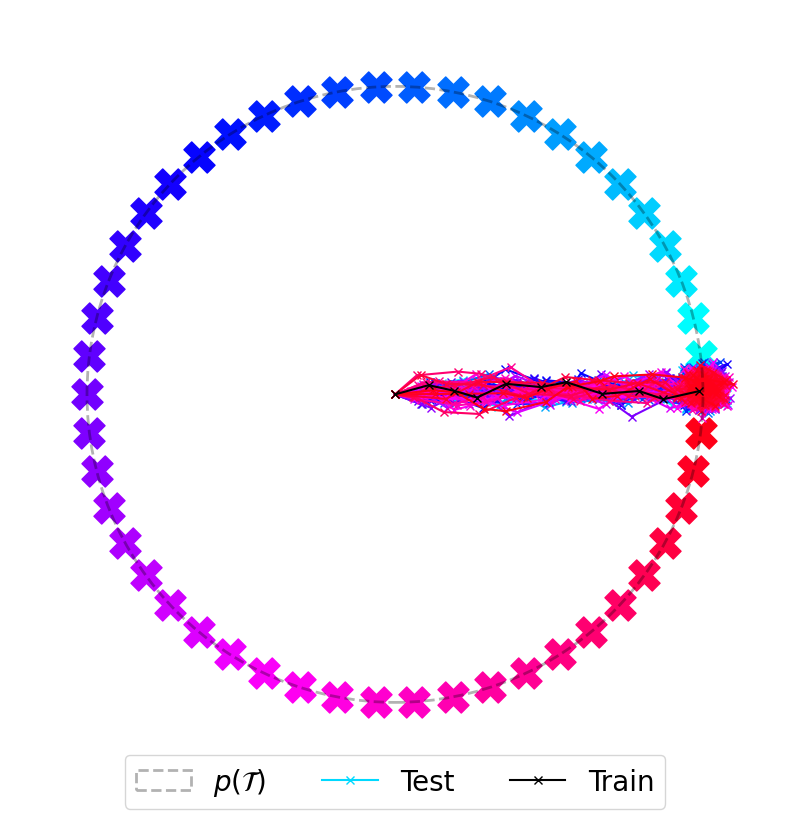

In [227]:
decoded_trajs_all_tasks_train = [DECODER(encoded_traj[:,:2]) for encoded_traj in encoded_trajs_all_tasks_train]
decoded_trajs_all_tasks_test = [DECODER(encoded_traj[:,:2]) for encoded_traj in encoded_trajs_all_tasks_test]

plot_rollouts_on_circle(train_trajectories=decoded_trajs_all_tasks_train,
                        test_trajectories=decoded_trajs_all_tasks_test,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_positions_test,
                        legend=True,
                        # savepath=None
                        # savepath="circle_nav_vanilla_meta_rl"
                        )

In [465]:
def sample_traj_of_hereditary_conj_env(base_task_tilde, base_policy_tilde, encoder, decoder, Lg, n_steps=100):
    """Rolls out a base policy in a new task by transforming the state and action spaces, not the reward and transition function."""

    # Trajectory of states, in the original state space representation
    tilde_traj_base = []

    # Get the state in the base task
    tilde_s_base = base_task_tilde.reset()
    # We record states in the base state representation to compare the different tasks. TODO, understand better why exactly we do this.
    tilde_traj_base.append(tilde_s_base.copy())

    # Push-forward the base state via l_g to the new task. Here, we use the conjugate of the left-action l_g as l_g
    # acts on S, so its conjugate acts on tilde(S).
    tilde_s_test = encoder(Lg @ decoder(tilde_s_base))

    for _ in range(n_steps):
        # Sample the policy in state of the test task
        tilde_a_test, _ = base_policy_tilde.predict(tilde_s_test, deterministic=True)
        tilde_s_base, _, done, _ = base_task_tilde.step(tilde_a_test)

        # Push-forward the base state via l_g to the new task
        tilde_s_test = encoder(Lg @ decoder(tilde_s_base))

        # We record states in the base state representation to compare the different tasks. TODO, understand better why exactly we do this.
        tilde_traj_base.append(tilde_s_base.copy())

        if done:
            break

    return np.array(tilde_traj_base)

In [353]:
def sample_traj_of_hereditary_conj_env(task, policy, Lg, encoder, decoder, n_steps=100):
    """Rolls out a base policy in a new task by transforming the state and action spaces, not the reward and transition function."""

    trajectory = []
    rewards = []
    actions = []

    obs_tilde = task.reset()
    trajectory.append(obs_tilde.copy())
    obs_base = encoder(Lg @ decoder(obs_tilde)) # Conjugate left-action

    for _ in range(n_steps):
        action_base, _ = policy.predict(obs_base, deterministic=True)
        obs_tilde, reward, done, _ = task.step(action_base)

        obs_base = encoder(Lg @ decoder(obs_tilde)) # Conjugate left-action

        actions.append(action_base)
        trajectory.append(obs_tilde.copy())
        rewards.append(reward)

        if done:
            break

    return np.array(trajectory)

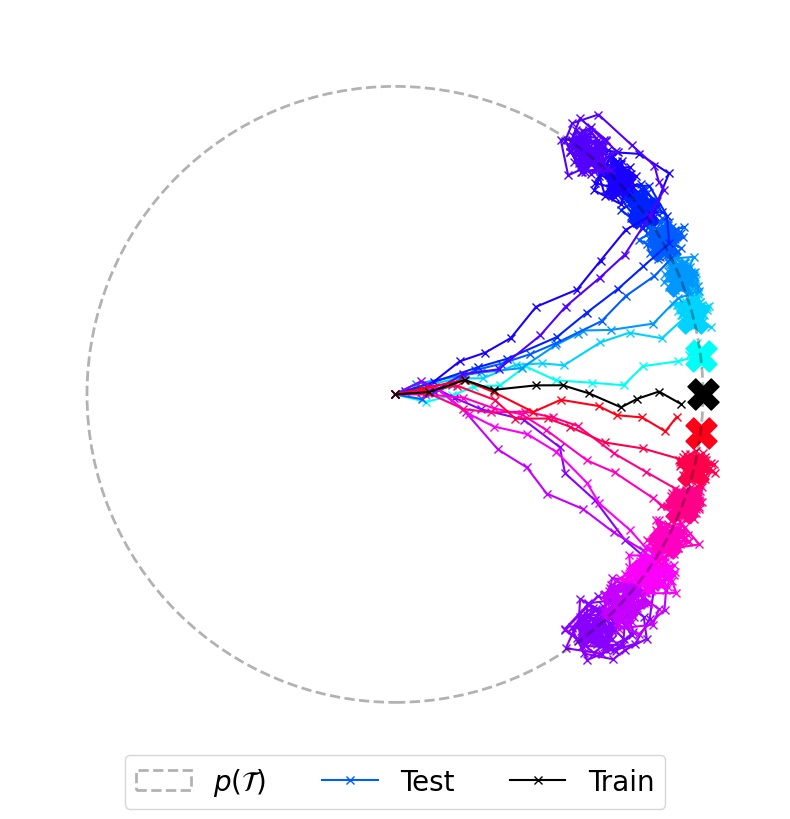

In [469]:
trajs_train_dec_her_train = [DECODER(encoded_traj[:,:2]) for encoded_traj in trajs_train_enc_her_train]
trajs_test_dec_her_test = [DECODER(encoded_traj[:,:2]) for encoded_traj in trajs_train_enc_her_test]

# trajs_train_dec_her_train = [encoded_traj for encoded_traj in trajs_train_enc_her_train]
# trajs_test_dec_her_test = [encoded_traj for encoded_traj in trajs_train_enc_her_test]

N_TRAJS_TO_PLOT=7
trajs_test_dec_her_test_plt = trajs_test_dec_her_test[:N_TRAJS_TO_PLOT] + trajs_test_dec_her_test[-N_TRAJS_TO_PLOT:]
goal_pos_test_plot = goal_positions_test[:N_TRAJS_TO_PLOT] + goal_positions_test[-N_TRAJS_TO_PLOT:]

plot_rollouts_on_circle(train_trajectories=trajs_train_dec_her_train,
                        test_trajectories=trajs_test_dec_her_test_plt,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_pos_test_plot,
                        legend=True,
                        # savepath=None
                        # savepath="circle_nav_sym_meta_rl"
                        )

## Conjugate Symmetry

In [361]:
KG = lambda theta : np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def sample_traj_of_conj_symmetric_env(task, policy, Kg, encoder, decoder):
    """Rolls out a base policy in a new task via symmetry by transforming the state and action spaces, not the reward and transition function."""

    trajectory = []
    n_steps = 100
    obs = task.reset()
    trajectory.append(obs.copy())
    obs_base = decoder(obs)

    for _ in range(n_steps):
        action_base, _ = policy.predict(obs_base, deterministic=True)
        action_tilde = Kg @ action_base
        obs, _, done, _ = task.step(action_tilde)
        trajectory.append(obs.copy())

        if done:
            break

    return np.array(trajectory)

In [459]:
KG = lambda theta : np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def sample_traj_of_conj_symmetric_env(tilde_base_task, policy, lg, hg, encoder, decoder, n_steps: int=100):
    """
    Rolls out a policy in a new task via symmetry by transforming the state and action spaces, not the reward and transition function.
    
    
    """
    _tilde_base_task = tilde_base_task.copy()
    _tilde_test_task = tilde_base_task.copy()
    del tilde_base_task

    trajectory = []
    tilde_s_base = tilde_base_task.reset()

    # Changes the state and action spaces of tilde_base_task into the state and action spaces of the current task (hereditary geometry)
    # Create task by acting on S via l_g. In more general form, we would also act on A via k_g.
    # Now, tilde_base_task's current state is rotated, e.g. we are in the new task (in the current state).
    tilde_s_task = lg @ tilde_s_base
    trajectory.append(tilde_s_base.copy())

    # However, the class tilde_base_task's current state is still in the base task. Thereby, when we call the policy in the next
    # step, it will still be optimal (on the initial states, not the task states).
    assert np.array_equal(tilde_s_base, tilde_base_task.s), "Not in base task anymore."

    # obs = encoder(Kg.T @ decoder(obs))
    
    for _ in range(n_steps):

        # Call the policy in the base state space
        tilde_a_base, _ = policy.predict(tilde_s_base, deterministic=True)

        # Update the action via symmetry to the optimal action in the new task
        action_tilde_task = hg @ tilde_a_base

        # Step in the base task, get the next state in the base task
        tilde_s_base, _, done, _ = tilde_base_task.step(action_tilde_task)

        # Update the current state to be in the new task
    #     # obs = encoder(Kg.T @ decoder(obs))
        tilde_s_task = lg @ tilde_s_base
        assert np.array_equal(tilde_s_base, tilde_base_task.s), "Not in base task anymore."

        trajectory.append(tilde_s_base.copy())

        if done:
            break

    return np.array(trajectory)

trajs_all_tasks_train_sym = []
trajs_all_tasks_test_sym = []

# Create environment, all tasks are now in same environment.
test_env = CircleRotation(s_goals=goal_positions_train, seed=RANDOM_SEED, encoder=ENCODER, decoder=DECODER)
test_env.reset()

for task_idx, goal_position in enumerate(goal_positions_all):
    g_action=CIRCLE_ANGLES[task_idx]
    hg_task = KG(g_action)
    lg_task = LG(g_action)

    # traj_equ = sample_traj_of_conj_symmetric_env(task=test_env, policy=encoded_model, Kg=Kg_task, encoder=ENCODER, decoder=DECODER)
    traj_equ = sample_traj_of_conj_symmetric_env(tilde_base_task=test_env, policy=encoded_model, lg=lg_task, hg=hg_task, encoder=ENCODER, decoder=DECODER)
    if any(np.array_equal(goal_position, s_goal) for s_goal in goal_positions_train):
        trajs_all_tasks_train_sym.append(traj_equ)
    else:
        trajs_all_tasks_test_sym.append(traj_equ)

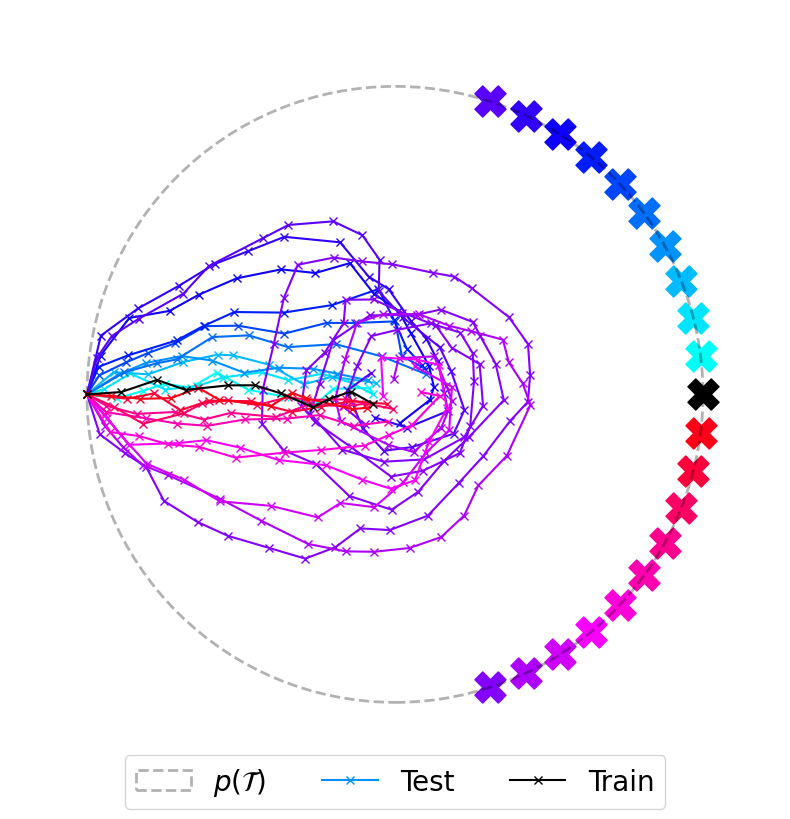

In [460]:
# decoded_sym_trajs_all_tasks_train = [DECODER(encoded_traj[:,:2]) for encoded_traj in trajs_all_tasks_train_sym]
# decoded_sym_trajs_all_tasks_test = [DECODER(encoded_traj[:,:2]) for encoded_traj in trajs_all_tasks_test_sym]

decoded_sym_trajs_all_tasks_train = [encoded_traj for encoded_traj in trajs_all_tasks_train_sym]
decoded_sym_trajs_all_tasks_test = [encoded_traj for encoded_traj in trajs_all_tasks_test_sym]


N_TRAJS_TO_PLOT=10
decoded_sym_trajs_test_plot = decoded_sym_trajs_all_tasks_test[:N_TRAJS_TO_PLOT] + decoded_sym_trajs_all_tasks_test[-N_TRAJS_TO_PLOT:]
goal_pos_test_plot = goal_positions_test[:N_TRAJS_TO_PLOT] + goal_positions_test[-N_TRAJS_TO_PLOT:]

plot_rollouts_on_circle(train_trajectories=decoded_sym_trajs_all_tasks_train,
                        test_trajectories=decoded_sym_trajs_test_plot,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_pos_test_plot,
                        legend=True,
                        # savepath=None
                        # savepath="circle_nav_sym_meta_rl"
                        )

## Plot Reward of all methods

In [232]:
def compute_return_of_traj(traj, goal):
    """Computes the return of a trajectory for a given goal."""
    reward=0
    done=False
    for state in traj:

        reward -= np.linalg.norm(state - goal)

        # Check if episode is done.
        if np.allclose(traj, goal, atol=0.2):
            done = True
            reward += 5
        if done:
            break
    return reward

In [261]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Returns oracle
return_oracle = [compute_return_of_traj(traj, goal) for traj, goal in zip(trajs_all_tasks_train, goal_positions_train)]

# Vanilla Meta-RL
returns_vanilla_meta_rl_train = [compute_return_of_traj(traj, goal) for traj, goal in zip(trajs_all_tasks_train, goal_positions_train)]
returns_vanilla_meta_rl_test = [compute_return_of_traj(traj, goal) for traj, goal in zip(trajs_all_tasks_test, goal_positions_test)]
returns_vanilla_meta_rl = np.array(returns_vanilla_meta_rl_train + returns_vanilla_meta_rl_test)
regret_vanilla_meta_rl = moving_average(return_oracle - returns_vanilla_meta_rl)

# Hereditary Geometry
returns_her_env_train = [compute_return_of_traj(traj, goal) for traj, goal in zip(trajs_her_env_train, goal_positions_train)]
returns_her_env_test = [compute_return_of_traj(traj, goal) for traj, goal in zip(trajs_her_env_test, goal_positions_test)]
returns_her_env = np.array(returns_her_env_train + returns_her_env_test)
regret_her_env = moving_average(return_oracle - returns_her_env)

# Vanilla Meta-RL w/ encoding
returns_enc_vanilla_meta_rl_train = [compute_return_of_traj(traj, goal) for traj, goal in zip(decoded_trajs_all_tasks_train, goal_positions_train)]
returns_enc_vanilla_meta_rl_test = [compute_return_of_traj(traj, goal) for traj, goal in zip(decoded_trajs_all_tasks_test, goal_positions_test)]
returns_enc_vanilla_meta_rl = np.array(returns_enc_vanilla_meta_rl_train + returns_enc_vanilla_meta_rl_test)
regret_enc_vanilla_meta_rl = moving_average(return_oracle - returns_enc_vanilla_meta_rl)

# Hereditary Geometry w/ encoding
returns_enc_her_env_train = [compute_return_of_traj(traj, goal) for traj, goal in zip(trajs_train_dec_her_train, goal_positions_train)]
returns_enc_her_env_test = [compute_return_of_traj(traj, goal) for traj, goal in zip(trajs_test_dec_her_test, goal_positions_test)]
returns_enc_her_env = np.array(returns_enc_her_env_train + returns_enc_her_env_test)
regret_enc_her_env = moving_average(return_oracle - returns_enc_her_env)

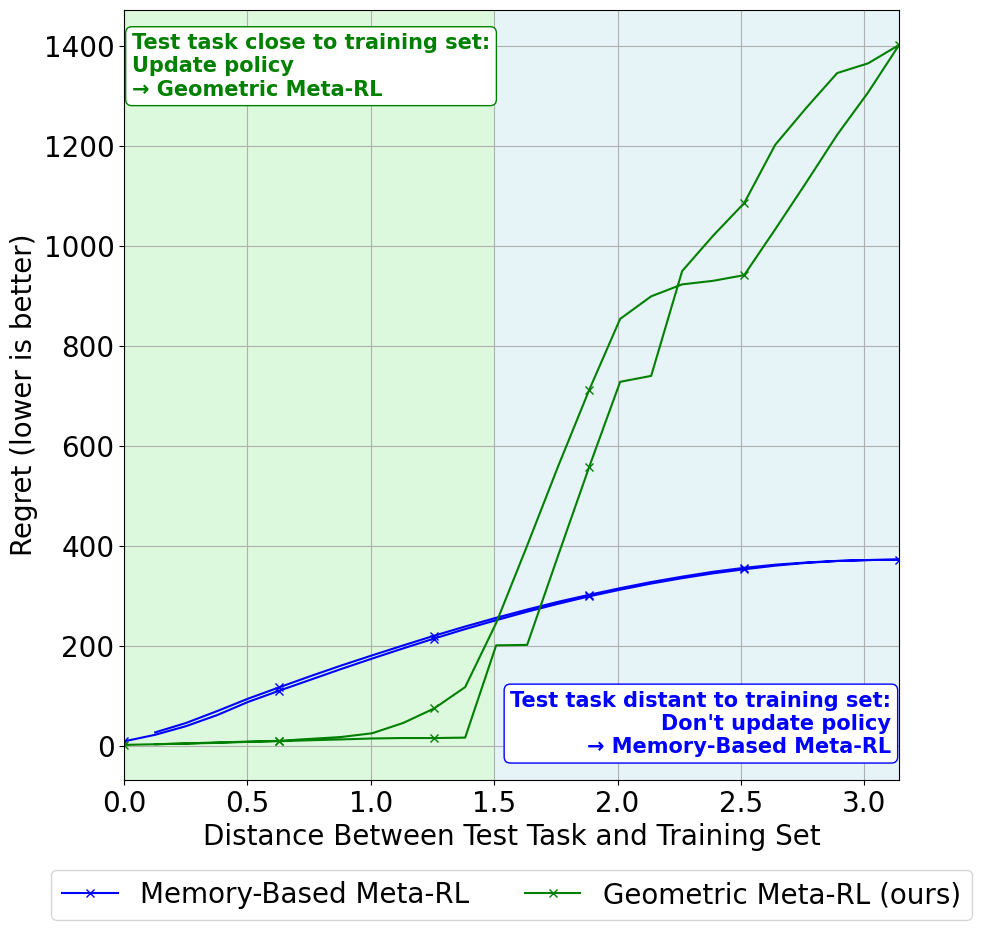

In [342]:
COLOR_VANILLA_META_RL="blue"
COLOR_HEREDITARY_GEO="green"
COLOR_HEREDITARY_SYM="red"
COLOR_ORACLE="orange"

MARKER_BASE="x"
MARKER_ENCODING="o"
MARKEVERY=5

distance_to_train_task = np.minimum(CIRCLE_ANGLES, 2 * np.pi - CIRCLE_ANGLES)

# Vanilla Meta-RL
fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

plt.plot(distance_to_train_task, regret_vanilla_meta_rl, label="Memory-Based Meta-RL", color=COLOR_VANILLA_META_RL, marker=MARKER_BASE, markevery=MARKEVERY)

# Hereditary Geometry
plt.plot(distance_to_train_task, regret_her_env, label="Geometric Meta-RL (ours)", color=COLOR_HEREDITARY_GEO, marker=MARKER_BASE, markevery=MARKEVERY)

# Hereditary Symmetry


# Background coloring
ax.set_xlim(min(distance_to_train_task), max(distance_to_train_task))
ax.axvspan(min(distance_to_train_task), 1.5, facecolor='lightgreen', alpha=0.3)
ax.axvspan(1.5, max(distance_to_train_task), facecolor='lightblue', alpha=0.3)

# Annotations
ax.text(0.01, 0.97, 'Test task close to training set:\nUpdate policy\n→ Geometric Meta-RL',
        transform=ax.transAxes,
        fontsize=0.75*LABEL_FONT_SIZE, color='green', fontweight='bold',
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

ax.text(0.99, 0.03, "Test task distant to training set:\nDon't update policy\n→ Memory-Based Meta-RL",
        transform=ax.transAxes,
        fontsize=0.75*LABEL_FONT_SIZE, color='blue', fontweight='bold',
        horizontalalignment='right', verticalalignment='bottom',
        bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))


# General
plt.ylabel("Regret (lower is better)", fontsize=LABEL_FONT_SIZE)
plt.xlabel("Distance Between Test Task and Training Set", fontsize=LABEL_FONT_SIZE)
# plt.yscale("log")
plt.legend(ncols=3, loc='lower center', bbox_to_anchor=(0.5, -0.2), fontsize=LABEL_FONT_SIZE)
ax.tick_params(axis='both', which='major', labelsize=LABEL_FONT_SIZE)

plt.grid()
